In [7]:
import matplotlib.pyplot as plt;
plt.style.use('huntstone')
import numpy as np
from scipy.constants import c
from scipy.interpolate import interp1d;
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import sys; 
#sys.path.insert(0, "..\\..\\python\\"); # Windows
sys.path.insert(0, "../../python"); # Ubuntu
sys.path.insert(0, "../current_profiles");
from crystal import crystal
import current_profiles as cp;
from ebeam import ebeam;
from laser import laser;
from plotting import makefig;
import phase_retard as pr;
import thz;
ind = 5

In [8]:
# Initialize crystal and their parameters
cry = crystal('GaP');
d    = 100e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

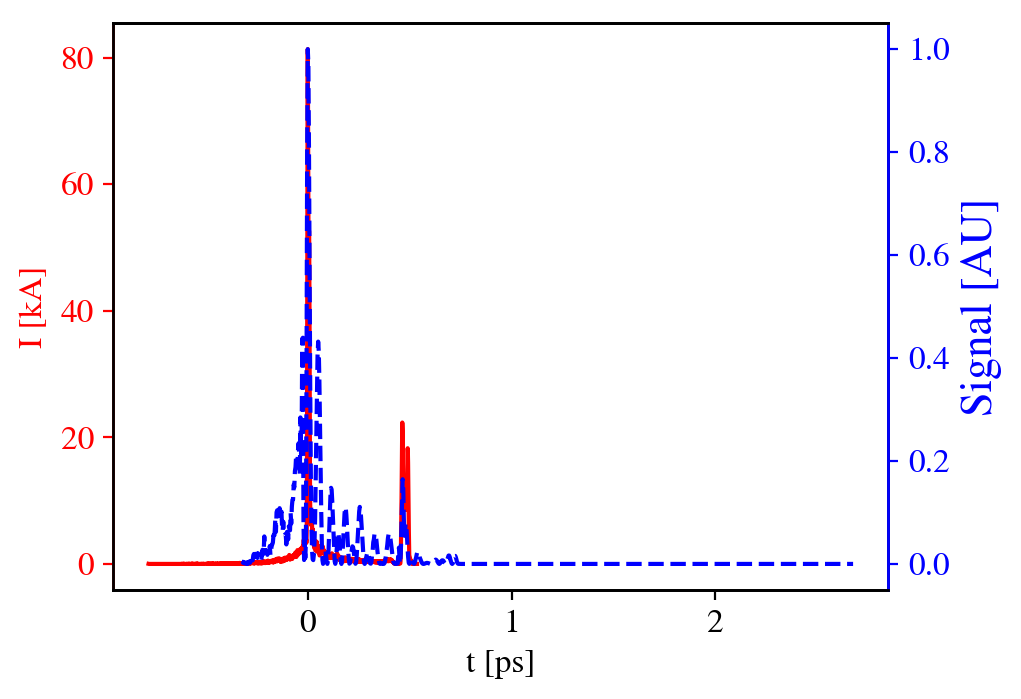

In [9]:
# Plot of Input current and Signal
# Load current profile
#%matplotlib notebook
I, ti, zi, dz, dt = cp.get_current(ind)
# Compute electric field
E, ze, te = cp.get_E(I, ti, zi, 5e-3)
# Make symmetric
N      = 1000
fE     = interp1d(te, E)
t_use  = min([abs(te[0]), te[-1]])
te_int = np.linspace(-t_use, t_use, N)
E_int  = np.flip(fE(te_int))
# Compute Signal
FEr, f = thz.raw_field(E_int, te_int);
Ec, tt = thz.cry_field(te_int, FEr, f, d, probe, cry, nslice = nslice, plot = False);
tau    = np.linspace(0, 3, 1000) * 1e-12
angle  = 15 * np.pi / 180 
gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle, plot = False)
sig    = np.sin(gamma / 2)**2
sig    = sig / max(sig)
# Center time
t_gamma = t_gamma - t_gamma[np.argmax(sig)]
# Plot
fig, ax1 = makefig(5, 3.75)
# Input current
ax1.spines['left'].set_color('r')
ax1.tick_params(axis = 'y', color = 'r')
ax1.tick_params(axis = 'y', labelcolor = 'r')
ax1.yaxis.label.set_color('r')
ax1.plot(ti * 1e12, I, '-r')
ax1.set_ylabel('I [kA]', color = 'r')
ax1.set_xlabel('t [ps]')

# Signal
ax2 = ax1.twinx()
ax2.spines['right'].set_color('b')
ax2.tick_params(axis = 'y', color = 'b')
ax2.tick_params(axis = 'y', labelcolor = 'b')
ax2.yaxis.label.set_color('b')
ax2.plot(t_gamma * 1e12, sig, '--b')
ax2.set_ylabel('Signal [AU]')
plt.show()

In [4]:
sig_locs, sig_ps = find_peaks(sig, height = 0.1, distance = 100)
I_locs, I_ps     = find_peaks(I, height = 15, distance = 436)
print(sig_locs, I_locs)
print('Current Ratio', I_ps['peak_heights'][1] / I_ps['peak_heights'][0])
print('Signal Ratio', sig_ps['peak_heights'][1] / sig_ps['peak_heights'][0])

[117 319] [ 753 1281]
Current Ratio 0.8826972869525631
Signal Ratio 0.5080003814923699


In [5]:
# Get noise
t_start = 0.08* 1e-12
t_end   = 0.5e-12
ind1    = np.argmin(abs(t_gamma - t_start))
ind2    = np.argmin(abs(t_gamma - t_end))
noise   = np.mean(sig[ind1:ind2])
print('Peak to Noise', sig_ps['peak_heights'][1] / noise)

Peak to Noise 13.157089318482553
